# AR simulation

### 1. Imports and constants

In [66]:
%load_ext autoreload
%autoreload 2

import os
import copy
import sys
import time
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from lib.generate.generate_ar import generate_stationary_ar_coefficients, simulate_ar
from lib.dataprocessor.ArDataProcessor import ArDataProcessor
from lib.models.ArModale import ArModel
from lib.loss.Mse import Mse

# Add project to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def run_one_simulation_on_test_size(degree, seed, models, forced_ar_coefficients=None):
    # generate data
    if forced_ar_coefficients is  None:
        ar_coefficients = generate_stationary_ar_coefficients(degree=degree, seed=seed)
    else:
        ar_coefficients = forced_ar_coefficients
    series = simulate_ar(ar_coefficients, sigma, length, seed=seed)
    
    # process data
    x, y = data_processor.process(series)
    
    # split data
    train_size = int(length * train_ratio)
    test_size = int(length * test_ratio)
    theoretical_risk_estimator_size = int(length * theoretical_risk_estimator_ratio)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_test = x[train_size:train_size + test_size]
    y_test = y[train_size:train_size + test_size]
    x_theoretical_risk_estimator = x[-theoretical_risk_estimator_size:]
    y_theoretical_risk_estimator = y[-theoretical_risk_estimator_size:]
    
    
    
    test_predictions = {}
    theoretical_risk_predictions = {}
    
    test_predictions['y'] = np.ravel(y_test)
    theoretical_risk_predictions['y'] = np.ravel(y_theoretical_risk_estimator)
    
    # fit and predict for each model
    for model in models:
        model = model.fit(x_train, y_train)
        test_predictions[model.name] = np.ravel(model.predict(x_test))
        theoretical_risk_predictions[model.name] = np.ravel(model.predict(x_theoretical_risk_estimator))
    
    # oracle predictions
    oracle = ArModel(degree)
    oracle = oracle.force_coef(ar_coefficients)
    
    test_predictions['oracle'] = np.ravel(oracle.predict(x_test))
    theoretical_risk_predictions['oracle'] = np.ravel(oracle.predict(x_theoretical_risk_estimator))
    
    test_values_and_predictions = pd.DataFrame(test_predictions)
    theoretical_risk_estimator_values_and_predictions = pd.DataFrame(theoretical_risk_predictions)
    
    
    # loss
    test_loss = loss.compute_from_dataframe(test_values_and_predictions, [model.name for model in models])
    theoretical_risk = loss.compute_from_dataframe(theoretical_risk_estimator_values_and_predictions, [model.name for model in models]).mean(axis=0)
    
    # select best model
    non_oracle_models_loss = test_loss[[model.name for model in models]]
    best_model_theoretical_risk = []
    for m in range(1, test_size):
        sub_test_loss = non_oracle_models_loss[:m]
        best_model = sub_test_loss.mean(axis=0).idxmin()
        best_model_theoretical_risk.append(copy.deepcopy(theoretical_risk.loc[best_model]))

    return (best_model_theoretical_risk - theoretical_risk.loc['oracle'])/np.array(best_model_theoretical_risk).mean()

In [64]:
def plot_best_ar_model_theoretical_risk(degree, models, nb_simulations, max_test_size, forced_ar_coefficients=None):
    ar_theoretical_risk_diffs = []
    for seed in tqdm.tqdm(range(1, nb_simulations)):
        ar_theoretical_risk_diffs.append(run_one_simulation_on_test_size(degree, seed, models, forced_ar_coefficients))
    mean_best_model_theoretical_risk_ar = np.array(ar_theoretical_risk_diffs).mean(axis=0)
    max_test_size = min(max_test_size, len(mean_best_model_theoretical_risk_ar))
    # plot best_model_theoretical_risk
    #plt.figure(figsize=(20, 10))
    plt.plot(mean_best_model_theoretical_risk_ar[:max_test_size],".")
    plt.title(f'Error Differences between Best Model for AR_1 to AR_{max_degree} and Oracle(AR_{degree})')
    plt.xlabel('Test Size')
    plt.ylabel('Error Difference')
    plt.legend()
    plt.grid(True)
    #plt.show()
    return mean_best_model_theoretical_risk_ar

def plot_from_mean_theoretical_risk(mean_theoretical_risk, max_test_size, max_degree, degree):
    max_test_size = min(max_test_size, len(mean_theoretical_risk))
    plt.figure(figsize=(20, 10))
    plt.plot(mean_theoretical_risk[:max_test_size],".")
    plt.title(f'Error Differences between Best Model for AR_1 to AR_{max_degree} and Oracle(AR_{degree})')
    plt.xlabel('Test Size')
    plt.ylabel('Error Difference')
    plt.legend()
    plt.grid(True)
    plt.show()


In [58]:
# set constants
length = 100_000
train_ratio = 0.06
test_ratio = 0.04
theoretical_risk_estimator_ratio = 0.9
max_degree = 60
degree = 30
nb_simulations = 10 # fixer les coeff pour toutes les simulations
sigma = 0.1
max_test_size = int(train_ratio * length / 5)

100%|██████████| 9/9 [00:14<00:00,  1.65s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Elapsed time: 14.851626873016357


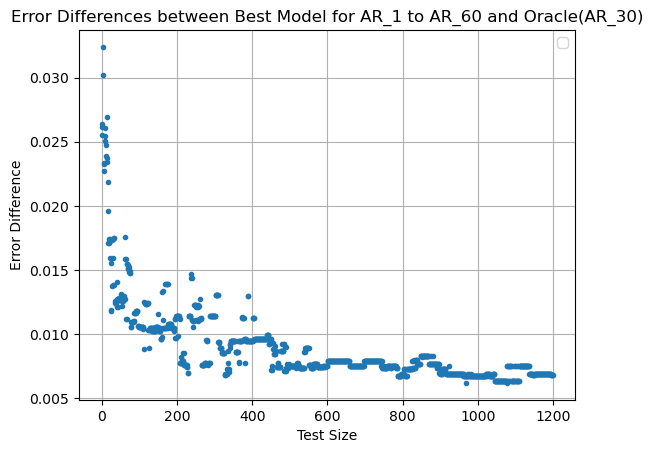

In [59]:
# simulation with multiple coefficients
START_TIME = time.time()
data_processor = ArDataProcessor('ar', max_degree)
ar_models = [ArModel(i) for i in range(1, max_degree)]
loss = Mse()
mean_theoretical_risk_ar = plot_best_ar_model_theoretical_risk(degree, ar_models, nb_simulations, max_test_size)
print(f'Elapsed time: {time.time() - START_TIME}')

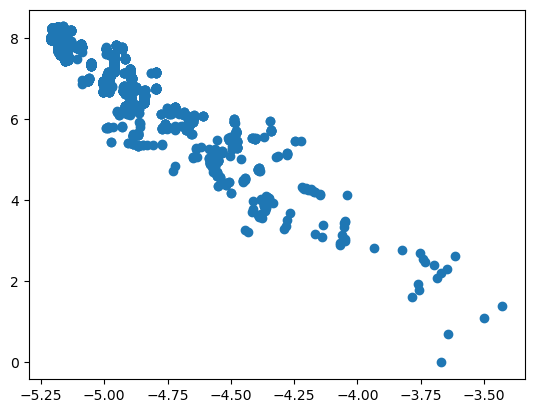

In [60]:
x = np.log(mean_theoretical_risk_ar)[1:]
y = np.log(np.array([i+1 for i in range(len(x))]))
plt.scatter(x, y)


In [62]:
# compute linear regression
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
model.coef_

array([-4.16062971])

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


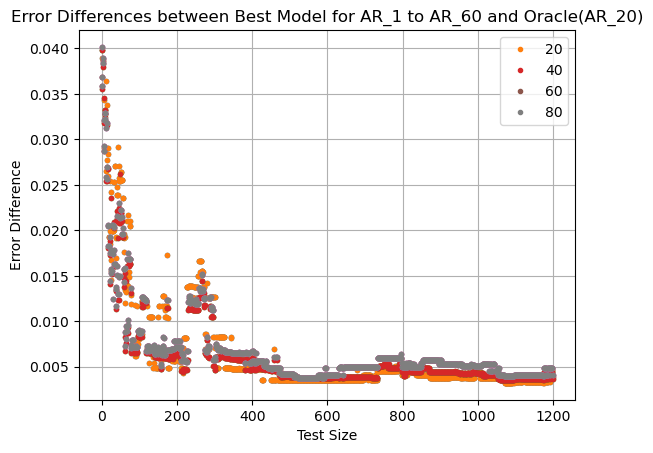

In [6]:
for i in range(20, 100, 20):
    mean_theoretical_risk_ar_i = plot_best_ar_model_theoretical_risk(degree, ar_models[:i], nb_simulations, max_test_size)
    plt.plot(mean_theoretical_risk_ar_i[:max_test_size],".", label=f"{i}")
plt.title(f'Error Differences between Best Model for AR_1 to AR_{max_degree} and Oracle(AR_{degree})')
plt.xlabel('Test Size')
plt.ylabel('Error Difference')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 9/9 [00:14<00:00,  1.62s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Elapsed time: 14.607475996017456


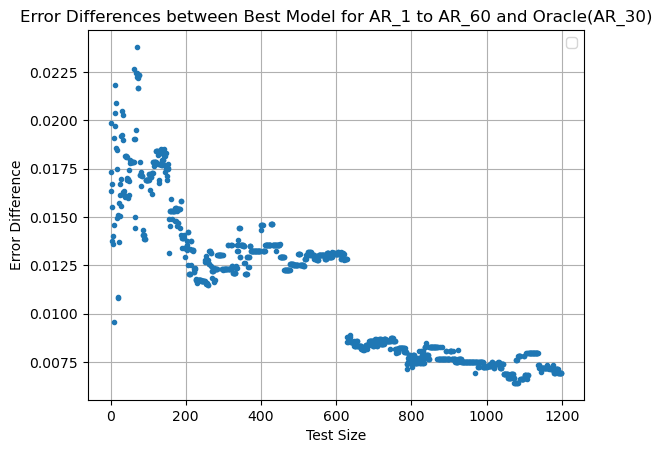

In [65]:
# simulation with forced coefficients
START_TIME = time.time()
data_processor = ArDataProcessor('ar', max_degree)
ar_models = [ArModel(i) for i in range(1, max_degree)]
loss = Mse()
forced_ar_coefficients = generate_stationary_ar_coefficients(degree=degree, seed=1)
mean_theoretical_risk_ar = plot_best_ar_model_theoretical_risk(degree, ar_models, nb_simulations, max_test_size, forced_ar_coefficients=forced_ar_coefficients)
print(f'Elapsed time: {time.time() - START_TIME}')

In [68]:
import threading
from queue import Queue
import tqdm
import numpy as np

def run_simulation_thread(models, oracle_coefficients, sigma, length, data_processor, train_ratio, loss, theo_risk_series, x_theo_risk, y_theo_risk, results_queue, sim_range, seed_start):
    train_length = int(train_ratio * length)
    test_length = length - train_length
    simulations = {}
    models_theo_risk = {model.name: [] for model in models}
    
    for i in sim_range:
        simulation = {}
        seed = seed_start + i
        # Générer les données
        series = simulate_ar(oracle_coefficients, sigma, length, seed=seed)
        # Traiter les données
        x, y = data_processor.process(series)
        x_train, y_train = x[:train_length], y[:train_length]
        x_test, y_test = x[train_length:], y[train_length:]
        # Ajuster les modèles
        for model in models:
            model = model.fit(x_train, y_train)
            model_loss_all_test = loss.compute(model.predict(x_test), y_test)
            model_theo_risk_loss = loss.compute(model.predict(x_theo_risk), y_theo_risk)
            model_theo_risk = model_theo_risk_loss.mean()
            simulation[model.name] = np.ravel(model_loss_all_test)
            models_theo_risk[model.name].append(model_theo_risk)
        simulations[i] = simulation

    # Mettre les résultats dans la queue
    results_queue.put((simulations, models_theo_risk, test_length))


def run_n_simulation_parallel(models, oracle_coefficients, loss, sigma, length, data_processor, n=20, train_ratio=0.6, theo_risk_estimator_length=10**6, seed=1, n_threads=4):
    # Pré-calcul du risque théorique
    theo_risk_series = simulate_ar(oracle_coefficients, sigma, theo_risk_estimator_length, seed=seed)
    x_theo_risk, y_theo_risk = data_processor.process(theo_risk_series)
    
    # File pour stocker les résultats de chaque thread
    results_queue = Queue()

    # Diviser les simulations entre les threads
    threads = []
    simulations_per_thread = n // n_threads
    extra_simulations = n % n_threads

    current_sim_start = 0
    for i in range(n_threads):
        # Calculer la plage de simulations pour chaque thread
        sim_range_length = simulations_per_thread + (1 if i < extra_simulations else 0)
        sim_range = range(current_sim_start, current_sim_start + sim_range_length)
        current_sim_start += sim_range_length

        thread = threading.Thread(target=run_simulation_thread, args=(
            models, oracle_coefficients, sigma, length, data_processor, train_ratio, loss, 
            theo_risk_series, x_theo_risk, y_theo_risk, results_queue, sim_range, seed))
        threads.append(thread)
        thread.start()

    # Attendre la fin de tous les threads
    for thread in threads:
        thread.join()

    # Collecter tous les résultats
    simulations = {}
    models_theo_risk = {model.name: [] for model in models}
    test_length = None

    while not results_queue.empty():
        thread_simulations, thread_models_theo_risk, thread_test_length = results_queue.get()
        simulations.update(thread_simulations)
        test_length = thread_test_length  # La longueur du test est la même pour toutes les simulations
        for model_name, model_theo_risks in thread_models_theo_risk.items():
            models_theo_risk[model_name].extend(model_theo_risks)
    
    # Moyenne des risques théoriques pour chaque modèle
    for model_name, model_theo_risks in models_theo_risk.items():
        models_theo_risk[model_name] = np.array(model_theo_risks).mean()

    return simulations, models_theo_risk, test_length

length = 10**3
sigma = 0.1
degree = 5
max_degree = 50

models = [ArModel(i) for i in range(1, max_degree)]
oracle_coefficients = generate_stationary_ar_coefficients(degree=degree, seed=1)
loss = Mse()
data_processor = ArDataProcessor('ar', max_degree)

simulations_1000, models_theo_risk_1000, test_length_1000 = run_n_simulation_parallel(models, oracle_coefficients, loss, sigma, length, data_processor, n=10, train_ratio=0.6, theo_risk_estimator_length=10**7, seed=1, n_threads=8)

In [69]:
simulations_1000, models_theo_risk_1000, test_length_1000 = run_n_simulation_parallel(models, oracle_coefficients, loss, sigma, length, data_processor, n=16, train_ratio=0.6, theo_risk_estimator_length=10**7, seed=1, n_threads=8)

In [70]:
simulations_1000, models_theo_risk_1000, test_length_1000 = run_n_simulation_parallel(models, oracle_coefficients, loss, sigma, length, data_processor, n=16, train_ratio=0.6, theo_risk_estimator_length=10**7, seed=1, n_threads=1)

In [71]:
simulations_1000, models_theo_risk_1000, test_length_1000 = run_n_simulation_parallel(models, oracle_coefficients, loss, sigma, length, data_processor, n=16, train_ratio=0.6, theo_risk_estimator_length=10**7, seed=1, n_threads=16)